In [1]:
%pip install -q tensorflow scikit-learn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Bidirectional, Add, Input, Attention, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

## Step 1: Data Splitting

In [3]:
# Parameters for LSTM workflow
CSV_PATH = 'btc_processed.csv' 
WINDOW_SIZE = 14  # sequence length
TRAIN_RATIO = 0.8  # chronological split: first 80% train, last 20% test
RANDOM_SEED = 42
TARGET_HORIZON = 7  # predict direction over N days

# Advanced settings
USE_ATTENTION = True  # add attention mechanism
USE_RESIDUAL = True   # residual connections in attention block
USE_FOCAL_LOSS = True # focal loss for class imbalance

df = pd.read_csv(CSV_PATH)

print(f'Window size: {WINDOW_SIZE}')
print(f'Target horizon: {TARGET_HORIZON} day(s)')
print(f'Attention={USE_ATTENTION}, Residual={USE_RESIDUAL}, FocalLoss={USE_FOCAL_LOSS}')

Window size: 14
Target horizon: 7 day(s)
Attention=True, Residual=True, FocalLoss=True


In [4]:
# # Feature Selection: Use ALL available features for maximum information
# # Including both raw OHLC prices and engineered features

# # Exclude date/timestamp, target, and future-leaking columns
# exclude = ['Target']
# if 'date' in df.columns:
#     exclude.append('date')
# if 'Date' in df.columns:
#     exclude.append('Date')
# if 'timestamp' in df.columns:
#     exclude.append('timestamp')
# # CRITICAL: Exclude future-leaking features that contain information not available at prediction time
# if 'next_day_close' in df.columns:
#     exclude.append('next_day_close')
#     print('⚠️  WARNING: Excluded "next_day_close" to prevent data leakage!')
# if 'next_day_open' in df.columns:
#     exclude.append('next_day_open')
# if 'future_price' in df.columns:
#     exclude.append('future_price')

# available_cols = [c for c in df.columns if c not in exclude]

# # Use ALL available features (excluding leakage)
# selected_features = available_cols

# print(f'Using {len(selected_features)} features from dataset (after removing leakage):')
# print('Features used:', selected_features)
# print('\nFeature categories:')
# # Categorize features for clarity
# raw_ohlc = [f for f in selected_features if f.lower() in ['open', 'high', 'low', 'close']]
# volumes = [f for f in selected_features if 'volume' in f.lower()]
# engineered = [f for f in selected_features if f not in raw_ohlc + volumes]

# if raw_ohlc:
#     print(f'  - Raw OHLC prices: {raw_ohlc}')
# if volumes:
#     print(f'  - Volume features: {volumes}')
# if engineered:
#     print(f'  - Engineered features: {engineered}')


X_all = df[[
    # Raw prices
    # "open", "high", "low", "close", "volume",
    
    # Lagged returns / spreads
    "Daily_Return", "High_Low_Spread", "Close_Open_Spread",
    
    # Technical indicators
    "rsi_7", "rsi_14", "cci_7", "cci_14",
    "sma_50", "ema_50", "sma_100", "ema_100",
    "macd", "bollinger", "TrueRange", "atr_7", "atr_14",
    
    # Log features (optional, may remove if redundant)
    "log_open", "log_high", "log_low", "log_close", "log_volume",
    "log_MA_7", "log_MA_30"
]].values.astype(float)

X_all = df[[
    # --- SAFE FEATURES (Relative/Oscillators) ---
    "Daily_Return", 
    "High_Low_Spread", 
    "Close_Open_Spread",
    
    "rsi_7", "rsi_14", 
    "cci_7", "cci_14",
    "macd",
]].copy()

# Fix ATR/TrueRange to be stationary
X_all['atr_7_pct'] = df['atr_7'] / df['close']
X_all['atr_14_pct'] = df['atr_14'] / df['close']
X_all['truerange_pct'] = df['TrueRange'] / df['close']

# Fix Moving Averages (Distance from MA)
# Instead of raw "50,000", use "Price is 5% above MA"
X_all['dist_sma_50'] = (df['close'] - df['sma_50']) / df['sma_50']
X_all['dist_ema_50'] = (df['close'] - df['ema_50']) / df['ema_50']

# Now select only the final columns
final_features = [
    "Daily_Return", "High_Low_Spread", "Close_Open_Spread",
    "rsi_7", "rsi_14", "cci_7", "cci_14", "macd",
    "atr_7_pct", "atr_14_pct", "truerange_pct",
    "dist_sma_50", "dist_ema_50"
]
X_final = X_all[final_features].values.astype(float)

X_all = X_final


y_all = df['Target']

y_all = df['Target'].values.astype(int)

print(f'\nData shape: {X_all.shape[0]} samples × {X_all.shape[1]} features')


Data shape: 3377 samples × 13 features


In [5]:
# Sequence creation (sliding windows)
def create_sequences(X, y, window_size):
    Xs = []
    ys = []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)
# Create windows
X_seq, y_seq = create_sequences(X_all, y_all, WINDOW_SIZE)
print('Sequence shapes: X', X_seq.shape, 'y', y_seq.shape)


Sequence shapes: X (3363, 14, 13) y (3363,)


In [6]:
# Chronological train-test split (no random shuffling)
n_samples = len(X_seq)
split_idx = int(n_samples * TRAIN_RATIO)
X_train = X_seq[:split_idx]
y_train = y_seq[:split_idx]
X_test = X_seq[split_idx:]
y_test = y_seq[split_idx:]
print('Train samples:', len(X_train), 'Test samples:', len(X_test))

Train samples: 2690 Test samples: 673


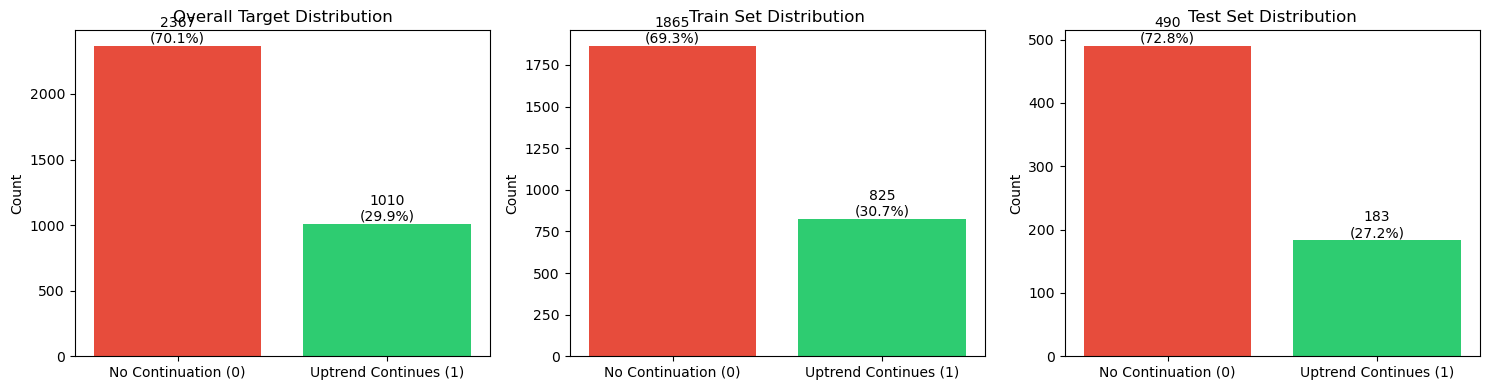


Class balance ratio (Uptrend Continues/No Continuation): 0.427


In [7]:
# Plot class distribution to check for imbalance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall class distribution
unique, counts = np.unique(y_all, return_counts=True)
axes[0].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts, color=['#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Target Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts)):
    axes[0].text(i, count, f'{count}\n({count/len(y_all)*100:.1f}%)', ha='center', va='bottom')

# Train set distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
axes[1].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train, color=['#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Count')
axes[1].set_title('Train Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_train)):
    axes[1].text(i, count, f'{count}\n({count/len(y_train)*100:.1f}%)', ha='center', va='bottom')

# Test set distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
axes[2].bar(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test, color=['#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Distribution')
for i, (label, count) in enumerate(zip(['No Continuation (0)', 'Uptrend Continues (1)'], counts_test)):
    axes[2].text(i, count, f'{count}\n({count/len(y_test)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f'\nClass balance ratio (Uptrend Continues/No Continuation): {counts[1]/counts[0]:.3f}')

- Normalization

In [8]:
# Scaling: Use RobustScaler for better handling of outliers in crypto data
n_features = X_train.shape[2]
scaler = RobustScaler()  # More robust to outliers than MinMaxScaler
# reshape (num_train_samples * window_size, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)
scaler.fit(X_train_reshaped)
# transform train and test, preserve 3D shape for LSTM/GRU
X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
X_test_reshaped = X_test.reshape(-1, n_features)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# Final tensors for LSTM
X_train_3d = X_train_scaled  # shape: (samples, window_size, features)
X_test_3d = X_test_scaled

print('✓ Using RobustScaler (better for crypto volatility)')
print('3D shape (for LSTM):', X_train_3d.shape, X_test_3d.shape)

✓ Using RobustScaler (better for crypto volatility)
3D shape (for LSTM): (2690, 14, 13) (673, 14, 13)


## Step 2: Model Training

In [9]:
# LSTM model with attention and focal loss
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Add, LayerNormalization, MultiHeadAttention, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow.keras.backend as K

# Focal Loss for handling class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
        weight = alpha * y_true * K.pow(1 - y_pred, gamma) + (1 - alpha) * (1 - y_true) * K.pow(y_pred, gamma)
        loss = weight * cross_entropy
        return K.mean(loss, axis=-1)
    return focal_loss_fixed

def build_lstm_model(window_size, n_features, lr=2e-4, dropout_rate=0.3):
    inputs = Input(shape=(window_size, n_features))
    # First Bi-LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.0005)))(inputs)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Second Bi-LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0005)))(x)
    x = LayerNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # Attention mechanism (if enabled)
    if USE_ATTENTION:
        attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
        x = Add()([x, attention_output])  # Residual connection
        x = LayerNormalization()(x)
    # Final LSTM layer
    x = LSTM(32, return_sequences=False, kernel_regularizer=l2(0.0005))(x)
    x = Dropout(dropout_rate)(x)
    # Dense layers
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.0005))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate * 0.7)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate * 0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
    loss_fn = focal_loss() if USE_FOCAL_LOSS else 'binary_crossentropy'
    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])
    return model

# Build LSTM
n_features = X_train_3d.shape[2]
model = build_lstm_model(WINDOW_SIZE, n_features)
print('\nBuilt LSTM model with attention:', USE_ATTENTION)
model.summary()


Built LSTM model with attention: True


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 14, 256)   │    145,408 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 14, 256)   │        512 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 256)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 14, 128)   │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ bidirectional_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 14, 128)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 14, 128)   │     66,048 │ dropout_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 14, 128)   │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 32)        │     20,608 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,112 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 401,921 (1.53 MB)

 Trainable params: 401,793 (1.53 MB)

 Non-trainable params: 128 (512.00 B)

In [10]:
# Train the LSTM with improved training strategy and explicit validation
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print('Class weights:', class_weights)

# Learning rate schedule with warmup
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr * (epoch + 1) / 5
    elif epoch < 30:
        return lr
    elif epoch < 60:
        return lr * 0.5
    elif epoch < 90:
        return lr * 0.25
    else:
        return lr * 0.1

es = EarlyStopping(monitor='val_auc', patience=25, restore_best_weights=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-7, mode='max', verbose=1)
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)
checkpoint = ModelCheckpoint('best_model_temp.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)

# Chronological explicit validation from tail of training
val_ratio = 0.15
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]
X_train_final = X_train_3d[:-val_size]
y_train_final = y_train[:-val_size]

print(f'\n🎯 Training samples: {len(X_train_final)}  |  Validation: {len(X_val)}  |  Test: {len(X_test_3d)}')
print(f'Using focal loss: {USE_FOCAL_LOSS}, Batch size: 64')

history = model.fit(
    X_train_final, y_train_final,
    epochs=200,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[es, reduce_lr, lr_scheduler, checkpoint],
    shuffle=False,
    verbose=2
)

print(f'\n✅ Training completed!')
print(f'Total epochs: {len(history.history["loss"])}')
print(f'Best val_loss: {min(history.history["val_loss"]):.4f}')
print(f'Best val_auc: {max(history.history["val_auc"]):.4f}')
if 'val_precision' in history.history:
    print(f'Best val_precision: {max(history.history["val_precision"]):.4f}')
    print(f'Best val_recall: {max(history.history["val_recall"]):.4f}')

Class weights: {0: 0.7211796246648794, 1: 1.6303030303030304}

🎯 Training samples: 2287  |  Validation: 403  |  Test: 673
Using focal loss: True, Batch size: 64
Epoch 1/200

Epoch 1: val_auc improved from -inf to 0.60297, saving model to best_model_temp.h5

Epoch 1: val_auc improved from -inf to 0.60297, saving model to best_model_temp.h5


36/36 - 6s - 159ms/step - accuracy: 0.5221 - auc: 0.5140 - loss: 0.5246 - precision: 0.3276 - recall: 0.4290 - val_accuracy: 0.6923 - val_auc: 0.6030 - val_loss: 0.4652 - val_precision: 0.2833 - val_recall: 0.4722 - learning_rate: 4.0000e-05
Epoch 2/200
Epoch 2/200

Epoch 2: val_auc improved from 0.60297 to 0.60851, saving model to best_model_temp.h5

Epoch 2: val_auc improved from 0.60297 to 0.60851, saving model to best_model_temp.h5


36/36 - 1s - 37ms/step - accuracy: 0.5509 - auc: 0.5344 - loss: 0.5081 - precision: 0.3514 - recall: 0.4303 - val_accuracy: 0.6600 - val_auc: 0.6085 - val_loss: 0.4659 - val_precision: 0.2593 - val_recall: 0.4861 - learning_rate: 1.6000e-05
Epoch 3/200
Epoch 3/200

Epoch 3: val_auc improved from 0.60851 to 0.61596, saving model to best_model_temp.h5

Epoch 3: val_auc improved from 0.60851 to 0.61596, saving model to best_model_temp.h5


36/36 - 2s - 44ms/step - accuracy: 0.5588 - auc: 0.5477 - loss: 0.5073 - precision: 0.3609 - recall: 0.4409 - val_accuracy: 0.6328 - val_auc: 0.6160 - val_loss: 0.4661 - val_precision: 0.2397 - val_recall: 0.4861 - learning_rate: 9.6000e-06
Epoch 4/200
Epoch 4/200

Epoch 4: val_auc did not improve from 0.61596
36/36 - 2s - 52ms/step - accuracy: 0.5549 - auc: 0.5318 - loss: 0.5138 - precision: 0.3568 - recall: 0.4382 - val_accuracy: 0.6328 - val_auc: 0.6145 - val_loss: 0.4656 - val_precision: 0.2432 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 5/200

Epoch 4: val_auc did not improve from 0.61596
36/36 - 2s - 52ms/step - accuracy: 0.5549 - auc: 0.5318 - loss: 0.5138 - precision: 0.3568 - recall: 0.4382 - val_accuracy: 0.6328 - val_auc: 0.6145 - val_loss: 0.4656 - val_precision: 0.2432 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 5/200

Epoch 5: val_auc improved from 0.61596 to 0.62045, saving model to best_model_temp.h5

Epoch 5: val_auc improved from 0.61596 to 0.620

36/36 - 2s - 52ms/step - accuracy: 0.5627 - auc: 0.5448 - loss: 0.5096 - precision: 0.3626 - recall: 0.4329 - val_accuracy: 0.6278 - val_auc: 0.6204 - val_loss: 0.4646 - val_precision: 0.2400 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 6/200
Epoch 6/200

Epoch 6: val_auc improved from 0.62045 to 0.62334, saving model to best_model_temp.h5

Epoch 6: val_auc improved from 0.62045 to 0.62334, saving model to best_model_temp.h5


36/36 - 2s - 52ms/step - accuracy: 0.5418 - auc: 0.5214 - loss: 0.5154 - precision: 0.3433 - recall: 0.4290 - val_accuracy: 0.6328 - val_auc: 0.6233 - val_loss: 0.4635 - val_precision: 0.2432 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 7/200
Epoch 7/200

Epoch 7: val_auc improved from 0.62334 to 0.62458, saving model to best_model_temp.h5

Epoch 7: val_auc improved from 0.62334 to 0.62458, saving model to best_model_temp.h5


36/36 - 2s - 51ms/step - accuracy: 0.5566 - auc: 0.5425 - loss: 0.5050 - precision: 0.3558 - recall: 0.4276 - val_accuracy: 0.6278 - val_auc: 0.6246 - val_loss: 0.4630 - val_precision: 0.2400 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 8/200
Epoch 8/200

Epoch 8: val_auc did not improve from 0.62458
36/36 - 2s - 50ms/step - accuracy: 0.5649 - auc: 0.5439 - loss: 0.5055 - precision: 0.3656 - recall: 0.4369 - val_accuracy: 0.6228 - val_auc: 0.6233 - val_loss: 0.4632 - val_precision: 0.2368 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 9/200

Epoch 8: val_auc did not improve from 0.62458
36/36 - 2s - 50ms/step - accuracy: 0.5649 - auc: 0.5439 - loss: 0.5055 - precision: 0.3656 - recall: 0.4369 - val_accuracy: 0.6228 - val_auc: 0.6233 - val_loss: 0.4632 - val_precision: 0.2368 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 9/200

Epoch 9: val_auc improved from 0.62458 to 0.62513, saving model to best_model_temp.h5

Epoch 9: val_auc improved from 0.62458 to 0.625

36/36 - 2s - 51ms/step - accuracy: 0.5802 - auc: 0.5679 - loss: 0.4987 - precision: 0.3851 - recall: 0.4608 - val_accuracy: 0.6179 - val_auc: 0.6251 - val_loss: 0.4645 - val_precision: 0.2338 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 10/200
Epoch 10/200

Epoch 10: val_auc improved from 0.62513 to 0.62582, saving model to best_model_temp.h5

Epoch 10: val_auc improved from 0.62513 to 0.62582, saving model to best_model_temp.h5


36/36 - 2s - 51ms/step - accuracy: 0.5654 - auc: 0.5423 - loss: 0.5059 - precision: 0.3677 - recall: 0.4449 - val_accuracy: 0.6079 - val_auc: 0.6258 - val_loss: 0.4653 - val_precision: 0.2278 - val_recall: 0.5000 - learning_rate: 7.6800e-06
Epoch 11/200
Epoch 11/200

Epoch 11: val_auc improved from 0.62582 to 0.62827, saving model to best_model_temp.h5

Epoch 11: val_auc improved from 0.62582 to 0.62827, saving model to best_model_temp.h5


36/36 - 3s - 74ms/step - accuracy: 0.5641 - auc: 0.5479 - loss: 0.5044 - precision: 0.3653 - recall: 0.4396 - val_accuracy: 0.6104 - val_auc: 0.6283 - val_loss: 0.4651 - val_precision: 0.2258 - val_recall: 0.4861 - learning_rate: 7.6800e-06
Epoch 12/200
Epoch 12/200

Epoch 12: val_auc improved from 0.62827 to 0.62873, saving model to best_model_temp.h5

Epoch 12: val_auc improved from 0.62827 to 0.62873, saving model to best_model_temp.h5


36/36 - 2s - 57ms/step - accuracy: 0.5527 - auc: 0.5335 - loss: 0.5018 - precision: 0.3445 - recall: 0.3971 - val_accuracy: 0.6079 - val_auc: 0.6287 - val_loss: 0.4655 - val_precision: 0.2208 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 13/200
Epoch 13/200

Epoch 13: val_auc improved from 0.62873 to 0.63255, saving model to best_model_temp.h5

Epoch 13: val_auc improved from 0.62873 to 0.63255, saving model to best_model_temp.h5


36/36 - 2s - 66ms/step - accuracy: 0.5715 - auc: 0.5605 - loss: 0.4986 - precision: 0.3732 - recall: 0.4436 - val_accuracy: 0.6129 - val_auc: 0.6326 - val_loss: 0.4647 - val_precision: 0.2237 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 14/200
Epoch 14/200

Epoch 14: val_auc did not improve from 0.63255
36/36 - 2s - 56ms/step - accuracy: 0.5763 - auc: 0.5670 - loss: 0.4981 - precision: 0.3776 - recall: 0.4422 - val_accuracy: 0.6278 - val_auc: 0.6317 - val_loss: 0.4627 - val_precision: 0.2329 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 15/200

Epoch 14: val_auc did not improve from 0.63255
36/36 - 2s - 56ms/step - accuracy: 0.5763 - auc: 0.5670 - loss: 0.4981 - precision: 0.3776 - recall: 0.4422 - val_accuracy: 0.6278 - val_auc: 0.6317 - val_loss: 0.4627 - val_precision: 0.2329 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 15/200

Epoch 15: val_auc improved from 0.63255 to 0.63444, saving model to best_model_temp.h5

Epoch 15: val_auc improved from 0.63255 

36/36 - 2s - 56ms/step - accuracy: 0.5767 - auc: 0.5706 - loss: 0.4945 - precision: 0.3783 - recall: 0.4436 - val_accuracy: 0.6551 - val_auc: 0.6344 - val_loss: 0.4608 - val_precision: 0.2519 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 16/200
Epoch 16/200

Epoch 16: val_auc improved from 0.63444 to 0.63467, saving model to best_model_temp.h5

Epoch 16: val_auc improved from 0.63444 to 0.63467, saving model to best_model_temp.h5


36/36 - 2s - 57ms/step - accuracy: 0.5715 - auc: 0.5422 - loss: 0.4986 - precision: 0.3660 - recall: 0.4117 - val_accuracy: 0.6501 - val_auc: 0.6347 - val_loss: 0.4624 - val_precision: 0.2482 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 17/200
Epoch 17/200

Epoch 17: val_auc improved from 0.63467 to 0.63780, saving model to best_model_temp.h5

Epoch 17: val_auc improved from 0.63467 to 0.63780, saving model to best_model_temp.h5


36/36 - 2s - 58ms/step - accuracy: 0.5645 - auc: 0.5575 - loss: 0.4974 - precision: 0.3633 - recall: 0.4290 - val_accuracy: 0.6427 - val_auc: 0.6378 - val_loss: 0.4623 - val_precision: 0.2429 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 18/200
Epoch 18/200

Epoch 18: val_auc improved from 0.63780 to 0.63939, saving model to best_model_temp.h5

Epoch 18: val_auc improved from 0.63780 to 0.63939, saving model to best_model_temp.h5


36/36 - 2s - 53ms/step - accuracy: 0.5811 - auc: 0.5681 - loss: 0.4903 - precision: 0.3790 - recall: 0.4263 - val_accuracy: 0.6402 - val_auc: 0.6394 - val_loss: 0.4628 - val_precision: 0.2411 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 19/200
Epoch 19/200

Epoch 19: val_auc improved from 0.63939 to 0.64262, saving model to best_model_temp.h5

Epoch 19: val_auc improved from 0.63939 to 0.64262, saving model to best_model_temp.h5


36/36 - 2s - 53ms/step - accuracy: 0.5676 - auc: 0.5547 - loss: 0.4940 - precision: 0.3589 - recall: 0.3984 - val_accuracy: 0.6427 - val_auc: 0.6426 - val_loss: 0.4609 - val_precision: 0.2391 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 20/200
Epoch 20/200

Epoch 20: val_auc did not improve from 0.64262
36/36 - 2s - 53ms/step - accuracy: 0.5798 - auc: 0.5715 - loss: 0.4868 - precision: 0.3703 - recall: 0.3944 - val_accuracy: 0.6476 - val_auc: 0.6407 - val_loss: 0.4609 - val_precision: 0.2426 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 21/200

Epoch 20: val_auc did not improve from 0.64262
36/36 - 2s - 53ms/step - accuracy: 0.5798 - auc: 0.5715 - loss: 0.4868 - precision: 0.3703 - recall: 0.3944 - val_accuracy: 0.6476 - val_auc: 0.6407 - val_loss: 0.4609 - val_precision: 0.2426 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 21/200

Epoch 21: val_auc did not improve from 0.64262
36/36 - 2s - 53ms/step - accuracy: 0.5881 - auc: 0.5680 - loss: 0.4882 - precisio

36/36 - 2s - 59ms/step - accuracy: 0.5894 - auc: 0.5746 - loss: 0.4877 - precision: 0.3849 - recall: 0.4130 - val_accuracy: 0.6576 - val_auc: 0.6467 - val_loss: 0.4577 - val_precision: 0.2500 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 23/200
Epoch 23/200

Epoch 23: val_auc improved from 0.64674 to 0.65255, saving model to best_model_temp.h5

Epoch 23: val_auc improved from 0.64674 to 0.65255, saving model to best_model_temp.h5


36/36 - 2s - 56ms/step - accuracy: 0.5864 - auc: 0.5699 - loss: 0.4907 - precision: 0.3863 - recall: 0.4356 - val_accuracy: 0.6725 - val_auc: 0.6525 - val_loss: 0.4565 - val_precision: 0.2619 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 24/200
Epoch 24/200

Epoch 24: val_auc improved from 0.65255 to 0.65473, saving model to best_model_temp.h5

Epoch 24: val_auc improved from 0.65255 to 0.65473, saving model to best_model_temp.h5


36/36 - 2s - 59ms/step - accuracy: 0.5925 - auc: 0.5873 - loss: 0.4853 - precision: 0.3948 - recall: 0.4462 - val_accuracy: 0.6749 - val_auc: 0.6547 - val_loss: 0.4569 - val_precision: 0.2640 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 25/200
Epoch 25/200

Epoch 25: val_auc did not improve from 0.65473
36/36 - 2s - 55ms/step - accuracy: 0.5955 - auc: 0.5773 - loss: 0.4854 - precision: 0.3938 - recall: 0.4236 - val_accuracy: 0.6725 - val_auc: 0.6494 - val_loss: 0.4569 - val_precision: 0.2619 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 26/200

Epoch 25: val_auc did not improve from 0.65473
36/36 - 2s - 55ms/step - accuracy: 0.5955 - auc: 0.5773 - loss: 0.4854 - precision: 0.3938 - recall: 0.4236 - val_accuracy: 0.6725 - val_auc: 0.6494 - val_loss: 0.4569 - val_precision: 0.2619 - val_recall: 0.4583 - learning_rate: 7.6800e-06
Epoch 26/200

Epoch 26: val_auc did not improve from 0.65473
36/36 - 2s - 55ms/step - accuracy: 0.5907 - auc: 0.5737 - loss: 0.4873 - precisio

36/36 - 2s - 55ms/step - accuracy: 0.5982 - auc: 0.5755 - loss: 0.4820 - precision: 0.3968 - recall: 0.4236 - val_accuracy: 0.6799 - val_auc: 0.6572 - val_loss: 0.4537 - val_precision: 0.2720 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 29/200
Epoch 29/200

Epoch 29: val_auc improved from 0.65723 to 0.66568, saving model to best_model_temp.h5

Epoch 29: val_auc improved from 0.65723 to 0.66568, saving model to best_model_temp.h5


36/36 - 2s - 54ms/step - accuracy: 0.6038 - auc: 0.5787 - loss: 0.4844 - precision: 0.4047 - recall: 0.4316 - val_accuracy: 0.6898 - val_auc: 0.6657 - val_loss: 0.4526 - val_precision: 0.2810 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 30/200
Epoch 30/200

Epoch 30: val_auc improved from 0.66568 to 0.66986, saving model to best_model_temp.h5

Epoch 30: val_auc improved from 0.66568 to 0.66986, saving model to best_model_temp.h5


36/36 - 2s - 55ms/step - accuracy: 0.5829 - auc: 0.5683 - loss: 0.4873 - precision: 0.3761 - recall: 0.4050 - val_accuracy: 0.6923 - val_auc: 0.6699 - val_loss: 0.4522 - val_precision: 0.2833 - val_recall: 0.4722 - learning_rate: 7.6800e-06
Epoch 31/200
Epoch 31/200

Epoch 31: val_auc did not improve from 0.66986
36/36 - 2s - 55ms/step - accuracy: 0.5977 - auc: 0.5797 - loss: 0.4810 - precision: 0.3960 - recall: 0.4223 - val_accuracy: 0.6948 - val_auc: 0.6677 - val_loss: 0.4529 - val_precision: 0.2857 - val_recall: 0.4722 - learning_rate: 3.8400e-06
Epoch 32/200

Epoch 31: val_auc did not improve from 0.66986
36/36 - 2s - 55ms/step - accuracy: 0.5977 - auc: 0.5797 - loss: 0.4810 - precision: 0.3960 - recall: 0.4223 - val_accuracy: 0.6948 - val_auc: 0.6677 - val_loss: 0.4529 - val_precision: 0.2857 - val_recall: 0.4722 - learning_rate: 3.8400e-06
Epoch 32/200

Epoch 32: val_auc did not improve from 0.66986
36/36 - 2s - 53ms/step - accuracy: 0.6078 - auc: 0.5768 - loss: 0.4827 - precisio

36/36 - 2s - 56ms/step - accuracy: 0.6143 - auc: 0.5922 - loss: 0.4780 - precision: 0.4148 - recall: 0.4170 - val_accuracy: 0.7097 - val_auc: 0.6700 - val_loss: 0.4502 - val_precision: 0.3009 - val_recall: 0.4722 - learning_rate: 3.0000e-08
Epoch 39/200
Epoch 39/200

Epoch 39: val_auc did not improve from 0.66998
36/36 - 2s - 54ms/step - accuracy: 0.6095 - auc: 0.5890 - loss: 0.4765 - precision: 0.4096 - recall: 0.4210 - val_accuracy: 0.7072 - val_auc: 0.6694 - val_loss: 0.4503 - val_precision: 0.2946 - val_recall: 0.4583 - learning_rate: 1.5000e-08
Epoch 40/200

Epoch 39: val_auc did not improve from 0.66998
36/36 - 2s - 54ms/step - accuracy: 0.6095 - auc: 0.5890 - loss: 0.4765 - precision: 0.4096 - recall: 0.4210 - val_accuracy: 0.7072 - val_auc: 0.6694 - val_loss: 0.4503 - val_precision: 0.2946 - val_recall: 0.4583 - learning_rate: 1.5000e-08
Epoch 40/200

Epoch 40: val_auc did not improve from 0.66998
36/36 - 2s - 60ms/step - accuracy: 0.5969 - auc: 0.5847 - loss: 0.4812 - precisio

36/36 - 2s - 55ms/step - accuracy: 0.5824 - auc: 0.5588 - loss: 0.4874 - precision: 0.3731 - recall: 0.3944 - val_accuracy: 0.7047 - val_auc: 0.6703 - val_loss: 0.4512 - val_precision: 0.2957 - val_recall: 0.4722 - learning_rate: 1.1719e-10
Epoch 47/200
Epoch 47/200

Epoch 47: val_auc did not improve from 0.67034
36/36 - 2s - 54ms/step - accuracy: 0.5938 - auc: 0.5759 - loss: 0.4832 - precision: 0.3889 - recall: 0.4090 - val_accuracy: 0.7047 - val_auc: 0.6684 - val_loss: 0.4502 - val_precision: 0.2920 - val_recall: 0.4583 - learning_rate: 5.8594e-11
Epoch 48/200

Epoch 47: val_auc did not improve from 0.67034
36/36 - 2s - 54ms/step - accuracy: 0.5938 - auc: 0.5759 - loss: 0.4832 - precision: 0.3889 - recall: 0.4090 - val_accuracy: 0.7047 - val_auc: 0.6684 - val_loss: 0.4502 - val_precision: 0.2920 - val_recall: 0.4583 - learning_rate: 5.8594e-11
Epoch 48/200

Epoch 48: val_auc did not improve from 0.67034
36/36 - 2s - 54ms/step - accuracy: 0.5877 - auc: 0.5642 - loss: 0.4863 - precisio

36/36 - 2s - 59ms/step - accuracy: 0.5877 - auc: 0.5689 - loss: 0.4877 - precision: 0.3812 - recall: 0.4050 - val_accuracy: 0.7047 - val_auc: 0.6706 - val_loss: 0.4515 - val_precision: 0.2957 - val_recall: 0.4722 - learning_rate: 1.8311e-12
Epoch 53/200
Epoch 53/200

Epoch 53: val_auc did not improve from 0.67063
36/36 - 2s - 58ms/step - accuracy: 0.5934 - auc: 0.5646 - loss: 0.4896 - precision: 0.3881 - recall: 0.4077 - val_accuracy: 0.7022 - val_auc: 0.6693 - val_loss: 0.4519 - val_precision: 0.2931 - val_recall: 0.4722 - learning_rate: 9.1553e-13
Epoch 54/200

Epoch 53: val_auc did not improve from 0.67063
36/36 - 2s - 58ms/step - accuracy: 0.5934 - auc: 0.5646 - loss: 0.4896 - precision: 0.3881 - recall: 0.4077 - val_accuracy: 0.7022 - val_auc: 0.6693 - val_loss: 0.4519 - val_precision: 0.2931 - val_recall: 0.4722 - learning_rate: 9.1553e-13
Epoch 54/200

Epoch 54: val_auc did not improve from 0.67063
36/36 - 2s - 54ms/step - accuracy: 0.5951 - auc: 0.5765 - loss: 0.4821 - precisio

## Step 3: Model Inferencing

In [11]:
# Threshold tuning on validation for LSTM (balanced-aware) with plots
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Validation split from tail of training (chronological) ---
val_ratio = 0.20
val_size = int(len(X_train_3d) * val_ratio)
X_val = X_train_3d[-val_size:]
y_val = y_train[-val_size:]

# --- Predict probabilities on validation ---
val_probs = model.predict(X_val, verbose=0).ravel()

# --- Compute ROC and PR curves ---
fpr, tpr, roc_thr = roc_curve(y_val, val_probs)
precision, recall, pr_thr = precision_recall_curve(y_val, val_probs)
auc_val = roc_auc_score(y_val, val_probs)

# Candidate thresholds (exclude last inf)
threshold_grid = pr_thr[:-1]

# --- Track best thresholds and metrics for plotting ---
best = {
    'f1': -1, 'thr_f1': 0.5,
    'bal_acc': -1, 'thr_bal': 0.5,
    'youden_j': -1, 'thr_j': 0.5
}
thr_list, f1_list, bal_acc_list = [], [], []

for thr in threshold_grid:
    y_hat = (val_probs >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat).ravel()

    # Metrics with small epsilon to avoid zero division
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    bal_acc = (tp/(tp+fn+1e-8) + tn/(tn+fp+1e-8)) / 2

    thr_list.append(thr); f1_list.append(f1); bal_acc_list.append(bal_acc)

    # Youden's J (maximize TPR - FPR) from ROC
    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    youden_thr = roc_thr[j_idx]

    # Track best thresholds
    if f1 > best['f1']:
        best['f1'] = f1
        best['thr_f1'] = thr
    if bal_acc > best['bal_acc']:
        best['bal_acc'] = bal_acc
        best['thr_bal'] = thr
    if j_scores[j_idx] > best['youden_j']:
        best['youden_j'] = j_scores[j_idx]
        best['thr_j'] = youden_thr

# --- Select threshold for balanced performance ---
threshold_to_use = best['thr_f1']  # choose max F1 or use 'thr_bal' for better class balance
print(f"Selected threshold (max F1): {threshold_to_use:.4f}")

# --- Apply threshold on test set ---
probs_test = model.predict(X_test_3d, verbose=0).ravel()
y_pred_optimal = (probs_test >= threshold_to_use).astype(int)


Selected threshold (max F1): 0.5601


## Model Evaluation

In [12]:
# --- Evaluation ---
cm = confusion_matrix(y_test, y_pred_optimal)
print("\nConfusion Matrix @ tuned threshold:")
print(cm)

print("\nClassification Report @ tuned threshold:")
print(classification_report(
    y_test,
    y_pred_optimal,
    target_names=['Down/Equal (0)', 'Up (1)'],
    digits=4
))


Confusion Matrix @ tuned threshold:
[[353 137]
 [103  80]]

Classification Report @ tuned threshold:
                precision    recall  f1-score   support

Down/Equal (0)     0.7741    0.7204    0.7463       490
        Up (1)     0.3687    0.4372    0.4000       183

      accuracy                         0.6434       673
     macro avg     0.5714    0.5788    0.5732       673
  weighted avg     0.6639    0.6434    0.6521       673



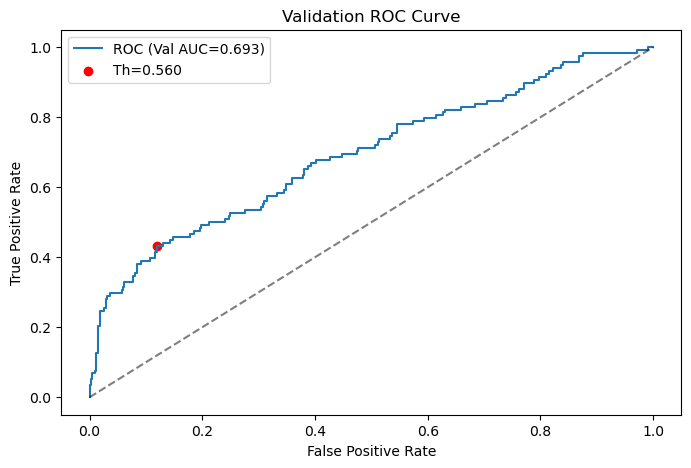

In [13]:
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'ROC (Val AUC={auc_val:.3f})', color='#1f77b4')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
# Mark point closest to selected threshold on ROC
idx_thr_roc = np.argmin(np.abs(roc_thr - threshold_to_use))
plt.scatter(fpr[idx_thr_roc], tpr[idx_thr_roc], color='red', label=f'Th={threshold_to_use:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curve')
plt.legend()

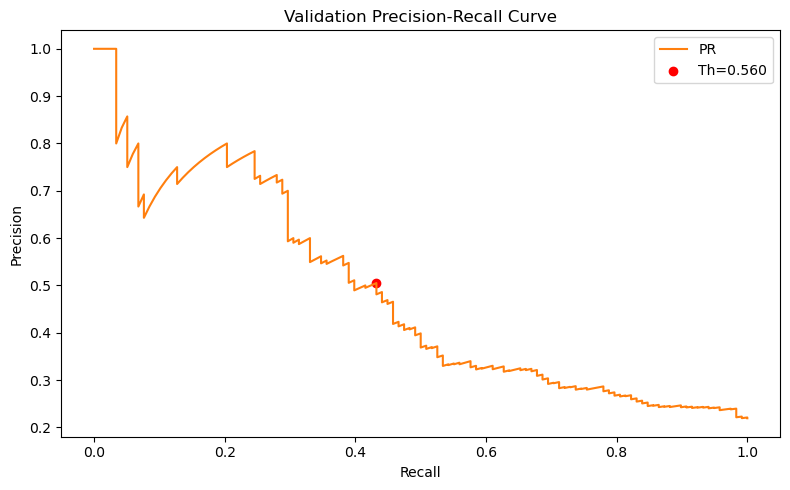

In [14]:
plt.figure(figsize=(8,5))
plt.plot(recall, precision, label='PR', color='#ff7f0e')
# Mark point closest to selected threshold on PR
idx_thr_pr = np.argmin(np.abs(pr_thr - threshold_to_use))
idx_thr_pr = np.clip(idx_thr_pr, 0, len(precision)-1)
plt.scatter(recall[idx_thr_pr], precision[idx_thr_pr], color='red', label=f'Th={threshold_to_use:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Validation Precision-Recall Curve')
plt.legend()
plt.tight_layout()
plt.show()

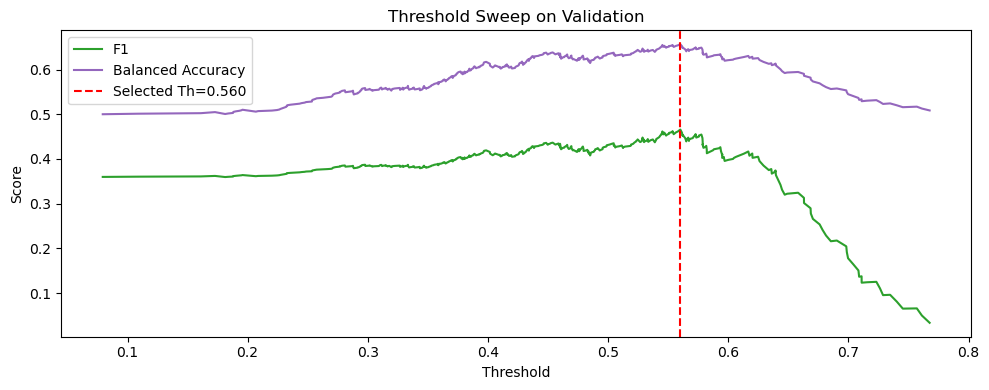

In [15]:
# Threshold vs F1 and Balanced Accuracy
plt.figure(figsize=(10,4))
plt.plot(thr_list, f1_list, label='F1', color='#2ca02c')
plt.plot(thr_list, bal_acc_list, label='Balanced Accuracy', color='#9467bd')
plt.axvline(threshold_to_use, color='red', linestyle='--', label=f'Selected Th={threshold_to_use:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sweep on Validation')
plt.legend()
plt.tight_layout()
plt.show()

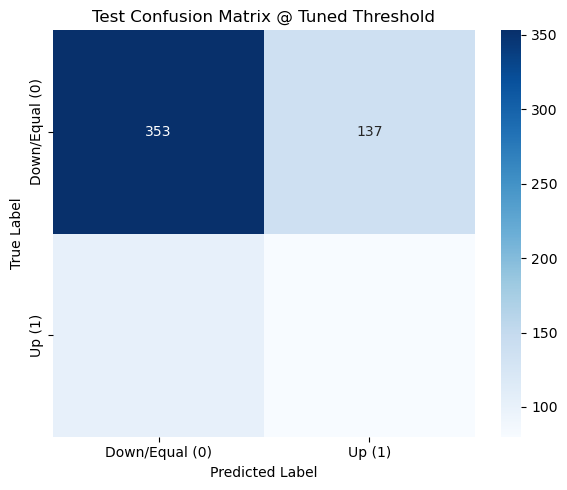

In [16]:

# Confusion Matrix Heatmap (Test @ tuned threshold)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down/Equal (0)', 'Up (1)'],
            yticklabels=['Down/Equal (0)', 'Up (1)'])
plt.title('Test Confusion Matrix @ Tuned Threshold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Loss')

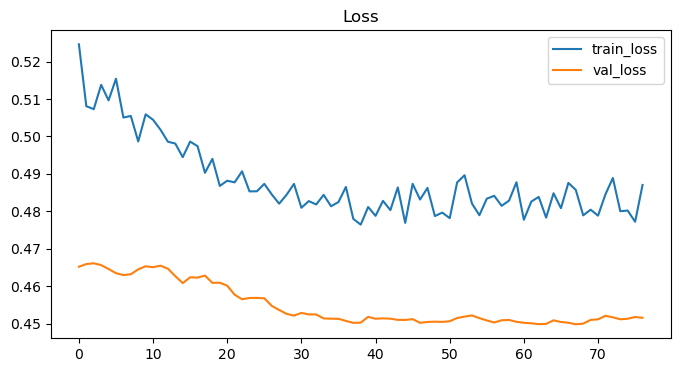

In [17]:
# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

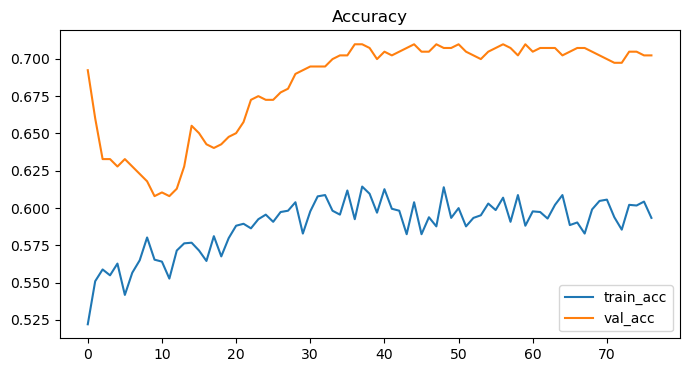

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')
plt.show()

In [19]:
# Evaluate on test set (consistent tensors)
results = model.evaluate(X_test_3d, y_test, verbose=0)
print('\nLSTM Test Results:')
print(f'  Loss: {results[0]:.4f}')
print(f'  Accuracy: {results[1]:.4f}')
print(f'  AUC: {results[2]:.4f}')
if len(results) > 3:
    print(f'  Precision: {results[3]:.4f}')
    print(f'  Recall: {results[4]:.4f}')
    f1 = 2 * (results[3] * results[4]) / (results[3] + results[4] + 1e-7)
    print(f'  F1-Score: {f1:.4f}')


LSTM Test Results:
  Loss: 0.4875
  Accuracy: 0.5929
  AUC: 0.6023
  Precision: 0.3415
  Recall: 0.5355
  F1-Score: 0.4170


In [20]:
# Save model (optional)
model.save('btc_dense_model.h5')
print('Saved model to btc_dense_model.h5')

Saved model to btc_dense_model.h5
